# 2 Deep Q Network 

In [ ]:
import torch
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import finite_MDP_env as env_mdp
import random
from collections import deque
from collections import namedtuple, deque
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


## 1. 
Please calculate the state value Vπ(s) and the state-action value Qπ(s, a) for state and
state-action pair from the following finite MDP under the given policy π and the discount
factor γ = 0.9:

####(a) 
Agent will use the uniform policy, which means that a1 and a2 will be evenly taken
by the agent

In [ ]:
e = env_mdp.environment()
prob_table = e.trans_probability
trans_table = e.transition
reward_table = e.trans_reward
done_list = e.done_list
policy_a = [0.5,0.5,0.5,0,0.5,0.5,0,0]


In [ ]:
def q_table(policy,prob,trans,reward,done,dis=0.9):
  state = np.ones([8,2])
  for j in done:
    state[j][0],state[j][1] = 0,0
    
  for i in range(7,-1,-1):
    if (state[i][0] == 0.):
      continue
    elif len(trans[i]) == 1:
      state[i,0] = prob[0][i]*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))+\
      (1-prob[0][i])*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))
      state[i,1] = prob[1][i]*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))+\
      (1-prob[1][i])*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))
    else:
      state[i,0] = prob[0][i]*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))+\
      (1-prob[0][i])*(reward[i][1]+dis*(policy[trans[i][1]]*state[trans[i][1],0]+(1-policy[trans[i][1]])*state[trans[i][1],1]))
      state[i,1] = prob[1][i]*(reward[i][0]+dis*(policy[trans[i][0]]*state[trans[i][0],0]+(1-policy[trans[i][0]])*state[trans[i][0],1]))+\
      (1-prob[1][i])*(reward[i][1]+dis*(policy[trans[i][1]]*state[trans[i][1],0]+(1-policy[trans[i][1]])*state[trans[i][1],1]))
  return state

def v_table(policy,prob,trans,reward,done,dis=0.9):
  state = np.ones(8)
  for j in done:
    state[j] = 0

  for i in range(7,-1,-1):

    if state[i] == 0.:
      continue
    elif len(trans[i]) == 1:
      state[i] =  policy[i]*prob[0][i]*(reward[i][0]+dis*state[trans[i][0]])+policy[i]*(1-prob[0][i])*(reward[i][0]+dis*state[trans[i][0]])+\
     (1-policy[i])*prob[1][i]*(reward[i][0]+dis*state[trans[i][0]])+(1-policy[i])*(1-prob[1][i])*(reward[i][0]+dis*state[trans[i][0]])
    else:
     state[i] =  policy[i]*prob[0][i]*(reward[i][0]+dis*state[trans[i][0]])+policy[i]*(1-prob[0][i])*(reward[i][1]+dis*state[trans[i][1]])+\
     (1-policy[i])*prob[1][i]*(reward[i][0]+dis*state[trans[i][0]])+(1-policy[i])*(1-prob[1][i])*(reward[i][1]+dis*state[trans[i][1]])
  return state
      
def table_cat(p):
  table = np.zeros([8,3]) 
  table[:,0] = v_table(p,prob_table,trans_table,reward_table,done_list,0.9)
  table[:,1:] = q_table(p,prob_table,trans_table,reward_table,done_list,0.9)
  return table

In [ ]:
t1 = table_cat(policy_a)
t1

array([[19.5675, 16.295 , 22.84  ],
       [ 9.75  ,  8.5   , 11.    ],
       [ 8.25  ,  8.75  ,  7.75  ],
       [ 0.    ,  0.    ,  0.    ],
       [30.    , 30.    , 30.    ],
       [ 5.    ,  8.    ,  2.    ],
       [ 0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ]])

In [ ]:
np.save('value_a.npy',t1)

#### (b)
Agent will use the specific policy which is denoted by π = [PS0, PS1, PS2, PS3, PS4] =
[0, 0, 1, 0, 1] where each element represents the probability that the agent will take
the action a1, in the other word, one minus that probability denotes the probability
that agent will take action a2

In [ ]:
policy_b = [0,0,1,0,0,1,0,0]

In [ ]:
t2 = table_cat(policy_b)
t2

array([[24.0676, 18.2408, 24.0676],
       [11.    ,  8.5   , 11.    ],
       [10.64  , 10.64  ,  8.56  ],
       [ 0.    ,  0.    ,  0.    ],
       [30.    , 30.    , 30.    ],
       [ 8.    ,  8.    ,  2.    ],
       [ 0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ]])

In [ ]:
np.save('value_b.npy',t2)

## 2.
In this part, you need to implement the Deep Q Network algorithm to estimate the Q value
from the previous finite MDP by using the DQN agent to interact with the environment.

##### (a)
Please follow the algorithm shown below to implement the DQN

In [ ]:
class net(nn.Module):
  def __init__(self,states,actions,hidden):
    super(net,self).__init__()
    self.layer = nn.Sequential(
        nn.Linear(states,hidden),
        nn.ReLU(),
        nn.Linear(hidden,actions)

    )
  def forward(self,x):
    h = self.layer(x)
    return h

In [ ]:
class DQN(object):
  def __init__(self,n_states,n_actions,n_hidden,batch,cap,re,gamma=0.9):
    self.eval = net(n_states,n_actions,n_hidden).to(device)
    self.target = net(n_states,n_actions,n_hidden).to(device)
    self.n_act = n_actions
    self.capacity = cap
    self.batch_size = batch
    self.gamma = gamma
    self.counter = 0
    self.m_state = np.zeros([self.capacity,n_states])
    self.m_n_state = np.zeros([self.capacity,n_states])
    self.m_actions = np.zeros([self.capacity,1])
    self.m_reward = np.zeros([self.capacity,1])
    self.loss_func = nn.MSELoss()
    self.opt = torch.optim.Adam(self.eval.parameters(), lr=0.01)
    self.renew_counter = 0
    self.renew = re


  def actions(self,state,epsilon):
    if random.random() < epsilon:
      action = np.random.randint(0,self.n_act)
    else:
      with torch.no_grad():
        act = self.eval(state)
        self.eval.train()
        action = torch.max(act,1)[1].data.cpu().numpy()[0]
    return action

  def store(self,state,action,reward,next_state):
    index = self.counter % self.capacity
    self.counter += 1
    self.m_state[index,:] = state
    self.m_n_state[index,:] = next_state
    self.m_actions[index] = action
    self.m_reward[index] = reward 

  def learn(self,done):
    sample = np.random.choice(self.counter,self.batch_size)
    b_action = torch.LongTensor(self.m_actions[sample,:]).to(device)
    b_state = torch.FloatTensor(self.m_state[sample,:]).to(device)
    b_n_state = torch.FloatTensor(self.m_n_state[sample,:]).to(device)
    b_reward = torch.FloatTensor(self.m_reward[sample,:]).to(device)
    q_eval = self.eval(b_state).gather(1,b_action)
    q_next = self.target(b_n_state).detach()
    target_q = b_reward + self.gamma*q_next.max(1)[0].view(self.batch_size,1)*(1-done) #max Q
    loss = self.loss_func(q_eval,target_q)
    self.opt.zero_grad()
    loss.backward()
    self.opt.step()

    self.renew_counter += 1
    if self.renew_counter == self.renew:
      self.target.load_state_dict(self.eval.state_dict())
      self.renew_counter = 0

In [ ]:
def train(model,environment,epoch,eps_start=1,eps_end=0.01,decay=0.995):
  final_rewards = []
  eps = eps_start
  window = deque(maxlen=100)
  for epo in range(epoch):
    d = False
    rewards = 0
    t = 0
    print(epo)
    state = environment.reset()
    while not d:
      x = torch.unsqueeze(torch.FloatTensor(state), 0).to(device)
      act = model.actions(x,eps)
      n_state,reward,d,_ = environment.step(act)
      model.store(state,act,reward,n_state)
      if model.counter > model.batch_size:
        model.learn(d)
      state = n_state
      rewards += reward
      eps = max(eps_end,eps*decay)
      if d:
        print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
        break
      t +=1
    final_rewards.append(rewards)
    window.append(rewards)
    if np.mean(window) >= 100.0:
      torch.save(model.eval.state_dict(), 'checkpoint.pth')
      break
  torch.save(model.eval.state_dict(), 'model_test.pth')
  return final_rewards,model

In [ ]:
dqn_mdp = DQN(8,2,50,32,100000,4)

In [ ]:
r_mdp,m_mdp = train(dqn_mdp,e,1000,1,0.1,0)

0
Episode finished after 3 timesteps, total rewards 22
1
Episode finished after 2 timesteps, total rewards 22
2
Episode finished after 3 timesteps, total rewards 22
3
Episode finished after 3 timesteps, total rewards 17
4
Episode finished after 2 timesteps, total rewards 22
5
Episode finished after 3 timesteps, total rewards 30
6
Episode finished after 3 timesteps, total rewards 30
7
Episode finished after 2 timesteps, total rewards 22
8
Episode finished after 3 timesteps, total rewards 17
9
Episode finished after 2 timesteps, total rewards 22
10
Episode finished after 3 timesteps, total rewards 30
11
Episode finished after 2 timesteps, total rewards 22
12
Episode finished after 3 timesteps, total rewards 30
13
Episode finished after 2 timesteps, total rewards 22
14
Episode finished after 3 timesteps, total rewards 30
15
Episode finished after 2 timesteps, total rewards 22
16
Episode finished after 2 timesteps, total rewards 22
17
Episode finished after 3 timesteps, total rewards 30
18

Text(0, 0.5, 'Rewards')

Text(0.5, 0, 'Episode')

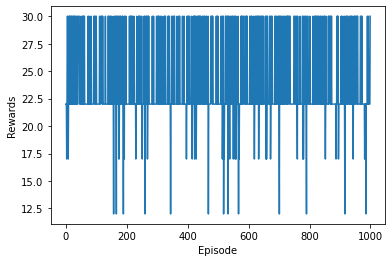

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(r_mdp)), r_mdp)
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.show()

##### (b)
Please analyze the difference between your answers by the calculation and the output
of the DQN

In [ ]:
s0 = np.array([[1,0,0,0,0,0,0,0]])
s1 = np.array([[0,1,0,0,0,0,0,0]])
s2 = np.array([[0,0,1,0,0,0,0,0]])
t1 = np.array([[0,0,0,1,0,0,0,0]])
s3 = np.array([[0,0,0,0,1,0,0,0]])
s4 = np.array([[0,0,0,0,0,1,0,0]])
t2 = np.array([[0,0,0,0,0,0,1,0]])
t3 = np.array([[0,0,0,0,0,0,0,1]])

In [ ]:
s0 = torch.FloatTensor(s0).to(device)
s1 = torch.FloatTensor(s1).to(device)
s2 = torch.FloatTensor(s2).to(device)
t1 = torch.FloatTensor(t1).to(device)
s3 = torch.FloatTensor(s3).to(device)
s4 = torch.FloatTensor(s4).to(device)
t2 = torch.FloatTensor(t2).to(device)
t3 = torch.FloatTensor(t3).to(device)

In [ ]:
q_dqn = np.zeros([8,2])
q_dqn[0,:] = m_mdp.eval(s0).detach().cpu().numpy()
q_dqn[1,:] = m_mdp.eval(s1).detach().cpu().numpy()
q_dqn[2,:] = m_mdp.eval(s2).detach().cpu().numpy()
q_dqn[3,:] = m_mdp.eval(t1).detach().cpu().numpy()
q_dqn[4,:] = m_mdp.eval(s3).detach().cpu().numpy()
q_dqn[5,:] = m_mdp.eval(s4).detach().cpu().numpy()
q_dqn[6,:] = m_mdp.eval(t2).detach().cpu().numpy()
q_dqn[7,:] = m_mdp.eval(t3).detach().cpu().numpy()        

In [ ]:
q_dqn

array([[12.74280739, 19.6137867 ],
       [ 9.24017048,  6.7651372 ],
       [ 8.69399261,  3.5939188 ],
       [11.37491035, 11.2886343 ],
       [34.51575089, 36.26284027],
       [12.70828629,  9.00026417],
       [10.47055912,  9.38796139],
       [ 9.6179285 ,  9.64674759]])

上表即為DQN對a1、a2的Q值表。和原本手算不同的是，T1、T2、T3的Q值並不為0，但其對應的兩個Q值十分趨近。而我發現此Q值是有跡可循的，舉S1時來說，若往左走能獲得7的rewards，往右走最終能獲得更多的rewards。所以選擇一個往右機率更大的活動a1是比較好的。而訓練出來的模型之Q值表能反映出此結論，此為我觀察所得之結論。

In [ ]:
np.save('q_dqn.npy',q_dqn)

### 3.
After the practice of DQN, now we can modify the input and the output sizes and the
other parameters of the DQN to train on the openAI gym environment LunarLander-v2

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender==1.0.8 
!pip install box2d-py
!pip install gym

In [ ]:
import gym
from colabgymrender.recorder import Recorder

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1859584/45929032 bytes (4.0%)5398528/45929032 bytes (11.8%)9281536/45929032 bytes (20.2%)13271040/45929032 bytes (28.9%)17186816/45929032 bytes (37.4%)21061632/45929032 bytes (45.9%)24887296/45929032 bytes (54.2%)28721152/45929032 bytes (62.5%)32727040/45929032 bytes (71.3%)36659200/45929032 bytes (79.8%)40550400/45929032 bytes (88.3%)44515328/45929032 bytes (96.9%)

In [ ]:
env = gym.make("LunarLander-v2")

In [ ]:
dqn = DQN(8,4,64,64,100000,4,0.9)

In [ ]:
r,d = train(dqn,env,100,1,0.01,0.995)

0
Episode finished after 146 timesteps, total rewards 0.6316508866905792
1
Episode finished after 106 timesteps, total rewards -194.94810435468932
2
Episode finished after 136 timesteps, total rewards -345.2490179198571
3
Episode finished after 113 timesteps, total rewards -174.9952834660747
4
Episode finished after 105 timesteps, total rewards -288.7888762100081
5
Episode finished after 88 timesteps, total rewards -151.49653965648602
6
Episode finished after 244 timesteps, total rewards -370.3067984372625
7
Episode finished after 244 timesteps, total rewards -138.48025662282294
8
Episode finished after 103 timesteps, total rewards -281.04133999158944
9
Episode finished after 96 timesteps, total rewards -230.3420407455769
10
Episode finished after 232 timesteps, total rewards -222.4995379536275
11
Episode finished after 137 timesteps, total rewards -373.3622850463836
12
Episode finished after 119 timesteps, total rewards -164.6040886984289
13
Episode finished after 224 timesteps, total

In [ ]:
dqn2 = DQN(8,4,64,64,100000,4,0.9)
dqn2.eval.load_state_dict(torch.load('model_test.pth'))
directory = './video'
env = Recorder(env, directory)
observation = env.reset()
terminal = False

while not terminal:
  x = torch.unsqueeze(torch.FloatTensor(observation), 0).to(device)
  action = dqn2.actions(x,0)
  observation, reward, terminal, info = env.step(action)

env.play()

<All keys matched successfully>

100%|█████████▉| 877/878 [00:02<00:00, 383.34it/s]


Text(0, 0.5, 'Rewards')

Text(0.5, 0, 'Episode')

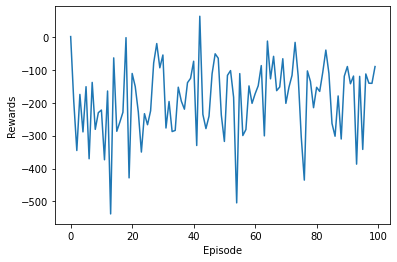

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(r)), r)
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.show()

##### (a)

和上題的圖比起來，此題rewards分布的值似乎也較多，似乎是能選擇的活動更多讓reward值十分多樣。而我訓練出的模型表現已不算太差，但收斂值並不會總維持在高點，收斂速度也有不小的差距，可看出agent及environment的不同會造成顯著的差異。

##### (b)

和上題MDP不同的是我增加了epsilon_start、epsilon_end、epsilon_decay等超參數。當隨機產生的值高過epsilon的時候，會隨機選擇活動到下一狀態，反之會根據Q值大小去選擇活動。我設置了decay超參數是要讓epsilon會隨著時間越來越小，直到小到epsilon_end的程度，讓狀態隨著訓練的結果去決定活動。而模型的訓練結果也不算太差。除此之外也有調整batch size及神經網路隱藏層節點個數來幫助訓練。